In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
# --- GRR Primitives ---
def grr_perturb(x, domain, epsilon):
    domain = list(domain)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    if np.random.rand() < p:
        return x
    return np.random.choice([v for v in domain if v != x])

def grr_estimate_frequencies(reports, domain, epsilon):
    domain = list(domain)
    n = len(reports)
    k = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + k - 1)
    q = 1.0 / (exp_eps + k - 1)

    counts = {v: 0 for v in domain}
    for r in reports:
        if r in counts:
            counts[r] += 1
        else:
            raise ValueError(f"Reported value '{r}' not in domain")

    return {v: (counts[v] - n * q) / (n * (p - q)) for v in domain}

In [5]:
def random_split_perturb(df, epsilon):
    """
    Each user perturbs all attributes using equal budget split.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    perturbed = []

    for _, row in df.iterrows():
        noisy_row = [
            grr_perturb(row[col], df[col].unique(), eps_attr)
            for col in df.columns
        ]
        perturbed.append(noisy_row)
    
    return perturbed

def random_split_estimate(reports, df, epsilon):
    """
    Estimate frequencies for each attribute independently.
    """
    k = len(df.columns)
    eps_attr = epsilon / k
    reports = np.array(reports)
    estimates = {}

    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        col_reports = reports[:, i]
        estimates[col] = grr_estimate_frequencies(col_reports, domain, eps_attr)

    return estimates


In [6]:
def rs_fd_perturb(df, domains, epsilon):
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    cols = list(domains.keys())
    
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        output = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                output[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                output[col] = np.random.choice(domain)
        privatized.append(output)
    
    return pd.DataFrame(privatized, index=df.index)


def rs_fd_estimate(perturbed_df, domains, epsilon):
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)  # Correct ε′
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        p = np.exp(epsilon_prime) / (np.exp(epsilon_prime) + kj - 1)
        q = 1.0 / (np.exp(epsilon_prime) + kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()

        est = {}
        for v in domain:
            Ni = counts.get(v, 0)
            est[v] = (Ni * d * kj - n * (d - 1 + q * kj)) / (n * kj * (p - q))
        estimates[col] = est

    return estimates




In [7]:
def rs_rfd_perturb(df, domains, priors, epsilon):
    """
    RS+RFD[GRR] client-side perturbation.

    Args:
        df       : DataFrame of true user data.
        domains  : dict mapping each attribute to its domain.
        priors   : dict of prior distributions (same structure as output of get_true_frequencies).
        epsilon  : privacy budget.

    Returns:
        DataFrame of privatized data.
    """
    n, d = df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    cols = list(df.columns)
    epsilon_prime = epsilon
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)  # index of sampled attribute
        y = {}
        for i, col in enumerate(cols):
            domain = domains[col]
            if i == j:
                # Sanitize sampled attribute with GRR
                y[col] = grr_perturb(row[col], domain, epsilon_prime)
            else:
                # Fake value sampled from prior
                prior_probs = [priors[col].get(v, 0.0) for v in domain]
                prior_probs = np.array(prior_probs)
                prior_probs /= prior_probs.sum()  # ensure normalization
                y[col] = np.random.choice(domain, p=prior_probs)
        privatized.append(y)

    return pd.DataFrame(privatized, index=df.index)
def rs_rfd_estimate(perturbed_df, domains, priors, epsilon):
    """
    RS+RFD[GRR] server-side frequency estimator.

    Args:
        perturbed_df : output of rs_rfd_perturb.
        domains      : dict of attribute → domain list.
        priors       : dict of attribute → {value: prior prob}.
        epsilon      : same ε used in perturbation.

    Returns:
        dict of attribute → {value: estimated frequency}.
    """
    n, d = perturbed_df.shape
    epsilon_prime = np.log(d * (np.exp(epsilon) - 1) + 1)
    epsilon_prime = epsilon
    estimates = {}
    for col, domain in domains.items():
        kj = len(domain)
        exp_eps = np.exp(epsilon_prime)
        p = exp_eps / (exp_eps + kj - 1)
        q = (1 - p) / (kj - 1)

        counts = perturbed_df[col].value_counts().to_dict()
        est = {}
        for v in domain:
            C_vi = counts.get(v, 0)
            f_prior = priors[col].get(v, 0.0)
            bias = q + (d - 1) * f_prior
            numerator = d * C_vi - n * bias
            denominator = n * (p - q)
            est[v] = numerator / denominator
        estimates[col] = est

    return estimates


In [8]:
# # import numpy as np
# # import pandas as pd

# # # --- Utilities ---
# # def grr_perturb(x, domain, epsilon):
# #     domain = list(domain)
# #     k = len(domain)
# #     p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
# #     if np.random.rand() < p:
# #         return x
# #     return np.random.choice([v for v in domain if v != x])

# # def grr_estimate(reports, domain, epsilon):
# #     n = len(reports)
# #     k = len(domain)
# #     p = np.exp(epsilon) / (np.exp(epsilon) + k - 1)
# #     q = 1.0 / (np.exp(epsilon) + k - 1)

# #     counts = {v: 0 for v in domain}
# #     for r in reports:
# #         counts[r] += 1

# #     return {v: (counts[v] - n * q) / (n * (p - q)) for v in domain}

# # # --- SPL Phase 1 ---
# # def spl_phase_1(df, epsilon):
# #     d = df.shape[1]
# #     eps_split = epsilon / d
# #     perturbed = []
# #     for _, row in df.iterrows():
# #         new_row = {col: grr_perturb(row[col], df[col].unique(), eps_split) for col in df.columns}
# #         perturbed.append(new_row)
# #     return pd.DataFrame(perturbed, columns=df.columns)

# # def estimate_from_spl(df, perturbed_df, epsilon):
# #     d = df.shape[1]
# #     eps_split = epsilon / d
# #     return {
# #         col: grr_estimate(perturbed_df[col].tolist(), df[col].unique(), eps_split)
# #         for col in df.columns
# #     }

# # # --- Optimal p_y Calculator ---
# # def optimal_p_y(f_a, f_b, epsilon, n, domain):
# #     d = len(domain)
# #     exp_eps = np.exp(epsilon)
# #     p = exp_eps / (exp_eps + d - 1)
# #     q = 1.0 / (exp_eps + d - 1)
# #     Δ = p - q

# #     S1 = d * (d - 1) / 2
# #     S2 = (d - 1) * d * (2 * d - 1) / 6

# #     μa = sum(v * f_a.get(v, 0.0) for v in domain)
# #     μb = sum(v * f_b.get(v, 0.0) for v in domain)
# #     νb2 = sum((v**2) * f_b.get(v, 0.0) for v in domain)

# #     a0 = μa - μb
# #     a1 = 2 * μb - S1
# #     b1 = 2 * νb2 - S2
# #     Y0 = (Δ / 2) * a0 + (S1 / 2)

# #     α1 = 2 * sum(
# #         (1 - f_a.get(v, 0.0) - f_b.get(v, 0.0)) *
# #         ((2 * f_a.get(v, 0.0) - 1) + (2 * f_b.get(v, 0.0) - 1))
# #         for v in domain
# #     )
# #     α2 = sum(
# #         (2 * f_a.get(v, 0.0) - 1)**2 + (2 * f_b.get(v, 0.0) - 1)**2
# #         for v in domain
# #     )

# #     num = (b1 - 2 * Y0 * a1) / (2 * n * Δ) + α1 / (8 * d)
# #     den = a1**2 / (2 * n) - α2 / (4 * d)

# #     p_star = num / den if den != 0 else 1
# #     return float(np.clip(p_star, 0.0, 1.0))
# import numpy as np
# import pandas as pd

# # --- Phase 2 Perturbation ---
# def phase2_perturb(df, epsilon, py_lookup, domain_map):
#     """
#     Each user perturbs one attribute with standard GRR (using ε), and the rest with GRR using p_y.
    
#     Args:
#         df         : original data (pandas DataFrame)
#         epsilon    : privacy budget
#         py_lookup  : dict of (perturbed_attr, other_attr) → p_y value
#         domain_map : dict of attribute → list of values
        
#     Returns:
#         perturbed DataFrame (same shape)
#         metadata of which attribute was selected per user (for use in estimation)
#     """
#     n, d = df.shape
#     cols = list(df.columns)
#     perturbed = []
#     selected_attr = []

#     exp_eps = np.exp(epsilon)
#     for _, row in df.iterrows():
#         selected = np.random.choice(cols)
#         selected_attr.append(selected)
#         noisy_row = {}

#         for col in cols:
#             domain = domain_map[col]
#             x = row[col]
#             if col == selected:
#                 # Regular GRR
#                 p = exp_eps / (exp_eps + len(domain) - 1)
#                 if np.random.rand() < p:
#                     noisy_row[col] = x
#                 else:
#                     noisy_row[col] = np.random.choice([v for v in domain if v != x])
#             else:
#                 # Correlation-aware GRR using p_y
#                 py = py_lookup.get((selected, col), 0.5)  # fallback if missing
#                 if np.random.rand() < py:
#                     noisy_row[col] = x
#                 else:
#                     noisy_row[col] = np.random.choice([v for v in domain if v != x])

#         perturbed.append(noisy_row)

#     return pd.DataFrame(perturbed, index=df.index), selected_attr

# # --- Phase 2 Estimator using regular GRR probabilities (p, q) ---
# def phase2_estimate_with_standard_grr(perturbed_df, selected_attr, epsilon, domain_map):
#     """
#     Estimate using standard GRR equations (p, q), regardless of actual py used.
#     """
#     n, d = perturbed_df.shape
#     eps_exp = np.exp(epsilon)

#     estimates = {}
#     for col, domain in domain_map.items():
#         k = len(domain)
#         p = eps_exp / (eps_exp + k - 1)
#         q = 1.0 / (eps_exp + k - 1)
#         counts = perturbed_df[col].value_counts().to_dict()

#         est = {}
#         for v in domain:
#             C_v = counts.get(v, 0)
#             est[v] = (C_v - n * q) / (n * (p - q))
#         estimates[col] = est

#     return estimates

# # --- Phase 2 Estimator using p_y and q_y for every attribute ---
# def phase2_estimate_with_py(perturbed_df, selected_attr, py_lookup, domain_map):
#     """
#     Estimate using custom p_y and q_y for each (selected_attr, other_attr) pair.
#     """
#     n, d = perturbed_df.shape
#     estimates = {col: {} for col in domain_map}

#     # Pre-collect counts
#     counts_by_col = {col: perturbed_df[col].value_counts().to_dict() for col in domain_map}

#     for col in domain_map:
#         k = len(domain_map[col])
#         for v in domain_map[col]:
#             C_v = counts_by_col[col].get(v, 0)
#             # Average p_y from all reports (can be refined)
#             avg_py = np.mean([
#                 py_lookup.get((sel, col), 0.5) for sel in selected_attr if col != sel
#             ]) if col not in selected_attr else None

#             if col in selected_attr:
#                 # Use regular GRR for attributes that were selected
#                 exp_eps = np.exp(epsilon)
#                 p = exp_eps / (exp_eps + k - 1)
#                 q = 1.0 / (exp_eps + k - 1)
#             else:
#                 # Use p_y and q_y for unselected attributes
#                 p = avg_py
#                 q = (1 - p) / (k - 1)

#             if p is None or q is None or p == q:
#                 est = 0.0
#             else:
#                 est = (C_v - n * q) / (n * (p - q))

#             estimates[col][v] = est

#     return estimates


In [9]:
import numpy as np
import pandas as pd

# --- p_y Optimization Function ---
def optimal_p_y(f_a, f_b, epsilon, n, domain):
    d = len(domain)
    exp_eps = np.exp(epsilon)
    p = exp_eps / (exp_eps + d - 1)
    q = 1.0 / (exp_eps + d - 1)
    Δ = p - q

    S1 = d*(d-1)/2
    S2 = (d-1)*d*(2*d-1)/6

    μa  = sum(v * f_a[v] for v in domain)
    μb  = sum(v * f_b[v] for v in domain)
    νb2 = sum(v**2 * f_b[v] for v in domain)

    a0 = μa - μb
    a1 = 2*μb - S1
    b1 = 2*νb2 - S2
    Y0 = (Δ/2)*a0 + (S1/2)

    α1 = 2 * sum((1 - f_a[v] - f_b[v]) * ((2*f_a[v]-1) + (2*f_b[v]-1)) for v in domain)
    α2 = sum((2*f_a[v]-1)**2 + (2*f_b[v]-1)**2 for v in domain)

    num = (b1 - 2*Y0*a1)/(2*n*Δ) + α1/(8*d)
    den = a1**2/(2*n) - α2/(4*d)

    p_star = num/den if den != 0 else 1
    return float(np.clip(p_star, 0.0, 1.0))

# --- Phase 1 SPL ---
def corr_rr_phase1_spl(df, epsilon, frac=0.1):
    n = len(df)
    m = int(frac * n)
    df_A = df.iloc[:m]
    eps_split = epsilon / df.shape[1]
    
    reports = []
    for _, row in df_A.iterrows():
        reports.append([
            grr_perturb(row[col], df[col].unique(), eps_split)
            for col in df.columns
        ])
    reports = np.array(reports)
    
    est = {}
    for i, col in enumerate(df.columns):
        domain = df[col].unique()
        est[col] = grr_estimate_frequencies(reports[:, i], domain, eps_split)
    return est, df.iloc[m:]

# --- Phase 2 Corr-RR Perturbation ---
def corr_rr_phase2_perturb(df, epsilon, f_hat_phase1, domain_map, p_y_table):
    d = len(df.columns)
    privatized = []
    for _, row in df.iterrows():
        j = np.random.randint(d)
        perturbed = {}
        for i, col in enumerate(df.columns):
            domain = domain_map[col]
            if i == j:
                perturbed[col] = grr_perturb(row[col], domain, epsilon)
            else:
                pair = (df.columns[j], col)
                py = p_y_table.get(pair, 0.5)
                if np.random.rand() < py:
                    perturbed[col] = row[col]
                else:
                    perturbed[col] = np.random.choice([v for v in domain if v != row[col]])
        privatized.append(perturbed)
    return pd.DataFrame(privatized, index=df.index)

# --- Corr-RR Estimator (using standard GRR) ---
def corr_rr_estimate(perturbed_df, domains, epsilon):
    estimates = {}
    n, d = perturbed_df.shape
    for col, domain in domains.items():
        reports = perturbed_df[col].tolist()
        estimates[col] = grr_estimate_frequencies(reports, domain, epsilon)
    return estimates

# --- Weighted Merge of Phase Estimates ---
def combine_phase_estimates(est_A, est_B, m, n_minus_m):
    combined = {}
    for col in est_A:
        combined[col] = {}
        for v in est_A[col]:
            combined[col][v] = (m * est_A[col][v] + n_minus_m * est_B[col][v]) / (m + n_minus_m)
    return combined


In [10]:
# --- True Frequency Utility ---
def get_true_frequencies(df, columns):
    freq_dict = {}
    for col in columns:
        counts = df[col].value_counts(normalize=True).sort_index()
        freq_dict[col] = counts.to_dict()
    return freq_dict

def correlated_data_generator(domain, n, correlations=None, total_attributes=None, seed=None):
    if seed is not None:
        np.random.seed(seed)

    domain = list(domain)
    domain_set = {x: [d for d in domain if d != x] for x in domain}
    df = pd.DataFrame()

    # Add correlated attributes
    if correlations:
        for attr1, attr2, p_same in correlations:
            X1 = np.random.choice(domain, size=n)
            mask = np.random.rand(n) < p_same
            X2 = np.where(mask, X1, [np.random.choice(domain_set[v]) for v in X1])
            df[attr1] = X1
            df[attr2] = X2

    # Decide which attributes to include
    if total_attributes is not None:
        all_attrs = [f'X{i+1}' for i in range(total_attributes)]
    else:
        all_attrs = list(df.columns)

    for attr in all_attrs:
        if attr not in df.columns:
            df[attr] = np.random.choice(domain, size=n)

    return df

# domain = [0, 1, 2, 3]
# correlations = [('X1', 'X2', 0.9), ('X3', 'X4', 0.9)]

# df = correlated_data_generator(domain, n=1000, correlations=correlations, total_attributes=2, seed=42)
# print(df.columns)  # ['X1', 'X2']
# print(df.head())

In [28]:
domain = list(range(2))
domain

[0, 1]

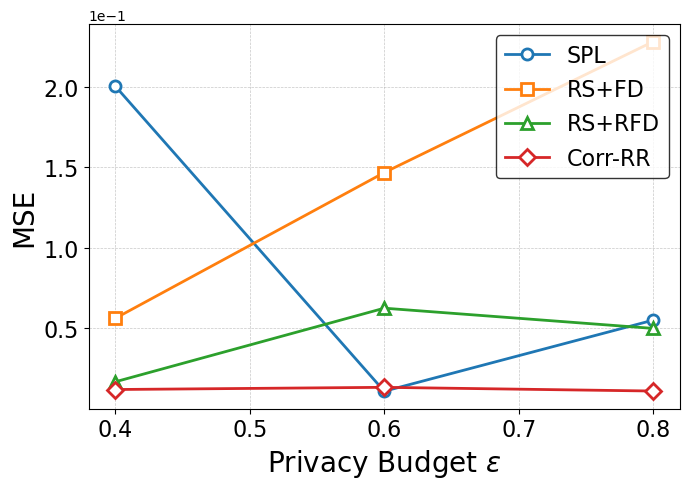

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assume helper functions already loaded from earlier cells:
# - random_split_perturb
# - random_split_estimate
# - rs_fd_perturb
# - rs_fd_estimate
# - rs_rfd_perturb
# - rs_rfd_estimate
# - get_true_frequencies
# - correlated_data_generator
# - corr_rr_phase1_spl
# - optimal_p_y
# - corr_rr_phase2_perturb
# - corr_rr_estimate
# - combine_phase_estimates

# --- Data Generation ---
domain = list(range(2))
correlations = [('X1', 'X2', 1)]
df = correlated_data_generator(domain, n=100, correlations=correlations)

columns = df.columns.tolist()
true_freqs = get_true_frequencies(df, columns)
priors = true_freqs
domain_sorted = sorted(domain)
domains = {col: sorted(df[col].unique()) for col in df.columns}
epsilons = [0.4, 0.6, 0.8]

# MSE containers
mse_spl = []
mse_rsfd = []
mse_rsrfd = []
mse_corrrr = []

for eps in epsilons:
    # SPL
    pert_spl = random_split_perturb(df, eps)
    est_spl = random_split_estimate(pert_spl, df, eps)
    mse_spl.append(np.mean([
        np.mean([(est_spl[col].get(v, 0.0) - true_freqs[col].get(v, 0.0)) ** 2 for v in domain_sorted])
        for col in columns
    ]))

    # RS+FD
    pert_rsfd = rs_fd_perturb(df, domains, eps)
    est_rsfd = rs_fd_estimate(pert_rsfd, domains, eps)
    mse_rsfd.append(np.mean([
        np.mean([(est_rsfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0)) ** 2 for v in domain_sorted])
        for col in columns
    ]))

    # RS+RFD
    pert_rsrfd = rs_rfd_perturb(df, domains, priors, eps)
    est_rsrfd = rs_rfd_estimate(pert_rsrfd, domains, priors, eps)
    mse_rsrfd.append(np.mean([
        np.mean([(est_rsrfd[col].get(v, 0.0) - true_freqs[col].get(v, 0.0)) ** 2 for v in domain_sorted])
        for col in columns
    ]))

    # Corr-RR
    phase1_est, df_B = corr_rr_phase1_spl(df, eps, frac=0.1)
    n_A = int(0.1 * len(df))
    n_B = len(df_B)

    p_y_table = {
        (a, b): optimal_p_y(phase1_est[a], phase1_est[b], eps, n_A, domain_sorted)
        for a in columns for b in columns if a != b
    }

    pert_corr_rr = corr_rr_phase2_perturb(df_B, eps, phase1_est, domains, p_y_table)
    est_corr_rr = corr_rr_estimate(pert_corr_rr, domains, eps)
    combined_est = combine_phase_estimates(phase1_est, est_corr_rr, n_A, n_B)

    mse_corrrr.append(np.mean([
        np.mean([(combined_est[col].get(v, 0.0) - true_freqs[col].get(v, 0.0)) ** 2 for v in domain_sorted])
        for col in columns
    ]))

# Plotting
plt.figure(figsize=(7, 5))

plt.plot(epsilons, mse_spl, linewidth=2, marker='o', markersize=8,
         markeredgewidth=2, markerfacecolor='white', label='SPL')

plt.plot(epsilons, mse_rsfd, linewidth=2, marker='s', markersize=8,
         markeredgewidth=2, markerfacecolor='white', label='RS+FD')

plt.plot(epsilons, mse_rsrfd, linewidth=2, marker='^', markersize=8,
         markeredgewidth=2, markerfacecolor='white', label='RS+RFD')

plt.plot(epsilons, mse_corrrr, linewidth=2, marker='D', markersize=8,
         markeredgewidth=2, markerfacecolor='white', label='Corr-RR')

plt.xlabel(r'Privacy Budget $\epsilon$', fontsize=20)
plt.ylabel('MSE', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
plt.legend(fontsize=16, loc='upper right', frameon=True, edgecolor='black')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


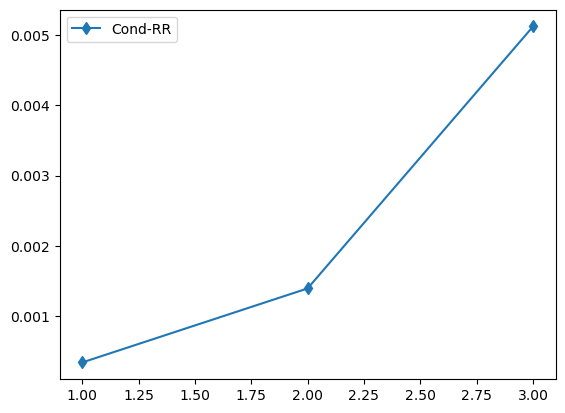

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --------------------------
# Helper: True frequencies
# --------------------------
def get_true_frequencies(df, columns):
    freq = {}
    for col in columns:
        counts = df[col].value_counts(normalize=True).sort_index()
        freq[col] = counts.to_dict()
    return freq

# --------------------------
# Helper: correlated data gen
# --------------------------
def correlated_data_generator(domain, n, correlations=None, total_attributes=None, seed=None):
    if seed is not None:
        np.random.seed(seed)
    domain = list(domain)
    domain_set = {x: [d for d in domain if d != x] for x in domain}
    df = pd.DataFrame()
    # add correlated pairs
    if correlations:
        for attr1, attr2, p_same in correlations:
            X1 = np.random.choice(domain, size=n)
            mask = np.random.rand(n) < p_same
            X2 = np.where(mask, X1,
                          [np.random.choice(domain_set[v]) for v in X1])
            df[attr1] = X1
            df[attr2] = X2
    # fill other attrs
    if total_attributes is not None:
        all_attrs = [f'X{i+1}' for i in range(total_attributes)]
    else:
        all_attrs = list(df.columns)
    for attr in all_attrs:
        if attr not in df.columns:
            df[attr] = np.random.choice(domain, size=n)
    return df

# --------------------------
# GRR for binary
# --------------------------
def grr_perturb_binary(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    if np.random.rand() < p:
        return x
    return 1 - x

def grr_matrix(epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    return np.array([[p, q],
                     [q, p]])

# --------------------------
# Cond-RR implementation
# --------------------------
def cond_rr(df, epsilon, m):
    n = len(df)
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]
    nB = n - m

    # Phase I: SPL @ epsilon/2 on both bits
    eps1 = epsilon / 2
    y_a = np.zeros((m, 2), dtype=int)
    for i, ui in enumerate(idx_a):
        y_a[i,0] = grr_perturb_binary(df.iloc[ui]['X1'], eps1)
        y_a[i,1] = grr_perturb_binary(df.iloc[ui]['X2'], eps1)
    counts = np.zeros(4)
    for pair in y_a:
        counts[pair[0]*2 + pair[1]] += 1
    Yhat = counts / m
    M1 = grr_matrix(eps1)
    M_A = np.kron(M1, M1)
    P_hat = np.linalg.solve(M_A, Yhat)
    P_hat = np.clip(P_hat, 0, None)
    P_hat /= P_hat.sum()

    # marginals from Phase I
    f1_spl = {v: P_hat[v*2+0] + P_hat[v*2+1] for v in [0,1]}
    f2_spl = {v: P_hat[0*2+v] + P_hat[1*2+v] for v in [0,1]}

    # conditional tables
    cond21 = {}
    for v in [0,1]:
        denom = P_hat[v*2+0] + P_hat[v*2+1]
        cond21[v] = [P_hat[v*2+w]/denom if denom>0 else 0.5 for w in [0,1]]
    cond12 = {}
    for w in [0,1]:
        denom = P_hat[0*2+w] + P_hat[1*2+w]
        cond12[w] = [P_hat[v*2+w]/denom if denom>0 else 0.5 for v in [0,1]]

    # Phase II: conditional perturbation
    eps2 = epsilon
    Y1_b = np.zeros(nB, dtype=int)
    Y2_b = np.zeros(nB, dtype=int)
    J = np.random.randint(1,3, size=nB)
    for i, ui in enumerate(idx_b):
        x1, x2 = df.iloc[ui]['X1'], df.iloc[ui]['X2']
        if J[i] == 1:
            y1 = grr_perturb_binary(x1, eps2)
            y2 = np.random.choice([0,1], p=cond21[y1])
        else:
            y2 = grr_perturb_binary(x2, eps2)
            y1 = np.random.choice([0,1], p=cond12[y2])
        Y1_b[i], Y2_b[i] = y1, y2

    # separate direct vs synthetic
    dir1 = (J==1); dir2=(J==2)
    n1, n2 = dir1.sum(), dir2.sum()
    p = np.exp(epsilon)/(np.exp(epsilon)+1)
    q = 1-p

    # f_rr and f_syn for attr1
    counts_rr1 = np.bincount(Y1_b[dir1], minlength=2)
    f_rr1 = {v:(counts_rr1[v]-n1*q)/(n1*(p-q)) if n1>0 else 0.5 for v in [0,1]}
    counts_syn1 = np.bincount(Y1_b[dir2], minlength=2)
    f_syn1 = {v:(counts_syn1[v]/n2) if n2>0 else 0.5 for v in [0,1]}
    f_star1 = {v:(n1/nB)*f_rr1[v] + (n2/nB)*f_syn1[v] for v in [0,1]}

    # attr2
    counts_rr2 = np.bincount(Y2_b[dir2], minlength=2)
    f_rr2 = {v:(counts_rr2[v]-n2*q)/(n2*(p-q)) if n2>0 else 0.5 for v in [0,1]}
    counts_syn2 = np.bincount(Y2_b[dir1], minlength=2)
    f_syn2 = {v:(counts_syn2[v]/n1) if n1>0 else 0.5 for v in [0,1]}
    f_star2 = {v:(n2/nB)*f_rr2[v] + (n1/nB)*f_syn2[v] for v in [0,1]}

    # combine phases
    f1_final = {v:(m*f1_spl[v] + nB*f_star1[v])/n for v in [0,1]}
    f2_final = {v:(m*f2_spl[v] + nB*f_star2[v])/n for v in [0,1]}
    return f1_final, f2_final

# --------------------------
# Main MSE-vs-ε loop
# --------------------------
domain = [0,1]
columns = ['X1','X2']
epsilons = [1,2,3]

# generate 2-attr binary df
df = correlated_data_generator(domain, n=100,
        correlations=[('X1','X2',1)], total_attributes=2, seed=42)
true_freqs = get_true_frequencies(df, columns)

m = int(0.1 * len(df))
mse_condrr = []
# also assume you have mse_spl, mse_rsfd, mse_rsrfd computed earlier

for eps in epsilons:
    f1c, f2c = cond_rr(df, eps, m)
    mse_condrr.append(np.mean([
        (f1c[v]-true_freqs['X1'][v])**2 for v in domain
    ] + [
        (f2c[v]-true_freqs['X2'][v])**2 for v in domain
    ])/2)

# Plot including Cond-RR
plt.plot(epsilons, mse_condrr, 'd-', label='Cond-RR')
plt.legend()
plt.show()


In [12]:
import numpy as np
import pandas as pd

# --- GRR primitives (binary case) ---
def grr_perturb_binary(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    if np.random.rand() < p:
        return x
    return 1 - x

def grr_matrix(epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    return np.array([[p, q],
                     [q, p]])

# --- Conditional-inferred RR (Cond-RR) for binary two-attribute ---
def cond_rr(df, epsilon, m):
    """
    Implements Cond-RR for binary two-attribute case.
    Args:
      df      : DataFrame with 'X1','X2' columns taking values 0 or 1
      epsilon : total LDP budget
      m       : number of Phase I users
    Returns:
      f1_final, f2_final : dicts {0: estimate, 1: estimate}
    """
    n = len(df)
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]
    nB = n - m

    # Phase I: joint estimation with SPL at epsilon/2
    eps1 = epsilon / 2
    # perturb both bits
    y_a = np.zeros((m,2), dtype=int)
    for i, ui in enumerate(idx_a):
        y_a[i,0] = grr_perturb_binary(df.iloc[ui]['X1'], eps1)
        y_a[i,1] = grr_perturb_binary(df.iloc[ui]['X2'], eps1)
    # empirical distribution of y pairs
    counts_y = np.zeros(4)
    for pair in y_a:
        counts_y[pair[0]*2 + pair[1]] += 1
    Yhat = counts_y / m
    # build channel matrix M_A = M(eps1) ⊗ M(eps1)
    M1 = grr_matrix(eps1)
    M_A = np.kron(M1, M1)  # 4x4
    P_hat = np.linalg.solve(M_A, Yhat)  # joint estimate [P00,P01,P10,P11]
    # ensure non-negative
    P_hat = np.clip(P_hat, 0, None)
    P_hat = P_hat / P_hat.sum()

    # marginal SPL estimates
    f1_spl = {v: P_hat[v*2 + 0] + P_hat[v*2 + 1] for v in [0,1]}
    f2_spl = {v: P_hat[0*2 + v] + P_hat[1*2 + v] for v in [0,1]}

    # Phase II: conditional perturbation
    eps2 = epsilon
    Y1_b = np.zeros(nB, dtype=int)
    Y2_b = np.zeros(nB, dtype=int)
    J = np.random.randint(1,3, size=nB)  # 1 or 2
    # compute conditional tables
    # Pr(X2=w | X1=v)
    cond21 = {
        v: [P_hat[v*2 + w] / (P_hat[v*2+0] + P_hat[v*2+1]) 
            if P_hat[v*2+0]+P_hat[v*2+1]>0 else 0.5
            for w in [0,1]]
        for v in [0,1]
    }
    # Pr(X1=w | X2=v)
    cond12 = {
        v: [P_hat[w*2 + v] / (P_hat[0*2+v] + P_hat[1*2+v]) 
            if P_hat[0*2+v]+P_hat[1*2+v]>0 else 0.5
            for w in [0,1]]
        for v in [0,1]
    }
    # generate Y_b
    for i, ui in enumerate(idx_b):
        x1, x2 = df.iloc[ui]['X1'], df.iloc[ui]['X2']
        if J[i] == 1:
            y1 = grr_perturb_binary(x1, eps2)
            y2 = np.random.choice([0,1], p=cond21[y1])
        else:
            y2 = grr_perturb_binary(x2, eps2)
            y1 = np.random.choice([0,1], p=cond12[y2])
        Y1_b[i], Y2_b[i] = y1, y2

    # separate direct and synthetic
    idx_dir1 = (J == 1)
    idx_dir2 = (J == 2)
    n1 = idx_dir1.sum()
    n2 = idx_dir2.sum()
    p = np.exp(epsilon)/(np.exp(epsilon)+1)
    q = 1-p

    # f_RR_1 using only direct
    counts_rr1 = np.bincount(Y1_b[idx_dir1], minlength=2)
    f_rr1 = {v: (counts_rr1[v] - n1*q) / (n1*(p-q)) if n1>0 else 0.5 for v in [0,1]}
    # f_SYN_1 using synthetic (when J=2)
    counts_syn1 = np.bincount(Y1_b[idx_dir2], minlength=2)
    f_syn1 = {v: counts_syn1[v]/n2 if n2>0 else 0.5 for v in [0,1]}
    # mixture f_star_1
    f_star1 = {v: (n1/nB)*f_rr1[v] + (n2/nB)*f_syn1[v] for v in [0,1]}

    # same for attribute 2
    counts_rr2 = np.bincount(Y2_b[idx_dir2], minlength=2)
    f_rr2 = {v: (counts_rr2[v] - n2*q) / (n2*(p-q)) if n2>0 else 0.5 for v in [0,1]}
    counts_syn2 = np.bincount(Y2_b[idx_dir1], minlength=2)
    f_syn2 = {v: counts_syn2[v]/n1 if n1>0 else 0.5 for v in [0,1]}
    f_star2 = {v: (n2/nB)*f_rr2[v] + (n1/nB)*f_syn2[v] for v in [0,1]}

    # combine Phase I + Phase II
    f1_final = {v: (m*f1_spl[v] + nB*f_star1[v]) / n for v in [0,1]}
    f2_final = {v: (m*f2_spl[v] + nB*f_star2[v]) / n for v in [0,1]}

    return f1_final, f2_final

# Example usage:
if __name__ == "__main__":
    # synthetic binary dataset
    n = 10000
    df = pd.DataFrame({
        'X1': np.random.binomial(1, 0.4, size=n),
        'X2': np.random.binomial(1, 0.6, size=n)
    })
    epsilon = 1.0
    m = int(0.2 * n)
    f1, f2 = cond_rr(df, epsilon, m)
    print("Cond-RR estimates X1:", f1)
    print("Cond-RR estimates X2:", f2)


Cond-RR estimates X1: {0: 0.6051182986747405, 1: 0.39488170132525946}
Cond-RR estimates X2: {0: 0.4049422733930487, 1: 0.5950577266069513}


In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- 0) generate a binary correlated dataset ---
n = 10000
p_corr = 0.8
X1 = np.random.binomial(1, 0.4, size=n)
X2 = [x if np.random.rand()<p_corr else 1-x for x in X1]
df = pd.DataFrame({'X1': X1, 'X2': X2})

# true marginals
true_freq1 = df['X1'].value_counts(normalize=True).sort_index().to_dict()
true_freq2 = df['X2'].value_counts(normalize=True).sort_index().to_dict()

# choose fraction m for Phase-I (Cond-RR) and SPL splitting
m = int(0.1 * n)

# ε values to sweep
epsilons = [0.5, 1.0, 1.5, 2.0]

# placeholders
mse_spl     = []
mse_rsfd    = []
mse_rsrfd   = []
mse_condrr  = []

# --- define or import your helper routines ---
# grr_perturb_binary, grr_estimate (binary), 
# random_split_perturb, random_split_estimate,
# rs_fd_perturb, rs_fd_estimate,
# rs_rfd_full_prior (or two‐phase),
# cond_rr  ← from previous cell

for eps in epsilons:
    # 1) SPL baseline
    pert_spl = random_split_perturb(df, ['X1','X2'], ['X1','X2'], eps)
    est1_spl, est2_spl = random_split_estimate(pert_spl, ['X1','X2'], ['X1','X2'], eps)
    mse_spl.append(np.mean([
        (est1_spl[v] - true_freq1[v])**2 for v in [0,1]
    ] + [
        (est2_spl[v] - true_freq2[v])**2 for v in [0,1]
    ])/2)

    # 2) RS+FD (uniform fake)
    pert_fd = rs_fd_perturb(df, {'X1':[0,1],'X2':[0,1]}, eps)
    est_fd = rs_fd_estimate(pert_fd, {'X1':[0,1],'X2':[0,1]}, eps)
    mse_rsfd.append(np.mean([
        (est_fd['X1'][v] - true_freq1[v])**2 for v in [0,1]
    ] + [
        (est_fd['X2'][v] - true_freq2[v])**2 for v in [0,1]
    ])/2)

    # 3) RS+RFD (full‐data prior)
    est_full = rs_rfd_full_prior(df, {'X1':[0,1],'X2':[0,1]}, eps)
    mse_rsrfd.append(np.mean([
        (est_full['X1'][v] - true_freq1[v])**2 for v in [0,1]
    ] + [
        (est_full['X2'][v] - true_freq2[v])**2 for v in [0,1]
    ])/2)

    # 4) Cond-RR
    f1_cond, f2_cond = cond_rr(df, eps, m)
    mse_condrr.append(np.mean([
        (f1_cond[v] - true_freq1[v])**2 for v in [0,1]
    ] + [
        (f2_cond[v] - true_freq2[v])**2 for v in [0,1]
    ])/2)

# --- Plot all four ---
plt.figure(figsize=(6,4))
plt.plot(epsilons, mse_spl,    'x--', label='SPL')
plt.plot(epsilons, mse_rsfd,   's-.', label='RS+FD')
plt.plot(epsilons, mse_rsrfd,  'd:',  label='RS+RFD')
plt.plot(epsilons, mse_condrr, 'o-',  label='Cond-RR')
plt.xlabel(r'$\epsilon$')
plt.ylabel('MSE')
plt.title('Binary (2‐attr) MSE vs ε')
plt.legend()
plt.grid(True)
plt.show()


TypeError: random_split_perturb() takes 2 positional arguments but 4 were given